# Cross-Validation of `lm` model

Make a k-fold cross-validation using natural years. _Leave-one-(natural year)-out_

In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openair))

suppressMessages(library(caret))
suppressMessages(library(BBmisc))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Representative sample 

In [4]:
sites.lv <- c("es0118a", "es1438a") # Big cities (Madrid and Barcelona)",
sites.lv <- c(sites.lv, "es1580a", "es1340a") # small cities (Santander and Huelva)

## DataFrame Creation

In [5]:
# Create dataSet
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01")
                  ) %>%
            timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01"))

df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        drop_na() %>%
        mutate_if(is.factor, as.character) %>%
        select(-date_end, -process, -summary, -validity)

rm(data_AQ)
rm(data_Mto)

## PreProcess

In [6]:
deseason <- function(cl) {
    # Remove seasonal component of the additive time serie.
    #     This function is called below by an apply
    
    dcomp <- decompose(ts(cl, frequency = 365))

    cl - dcomp$seasonal
}

scale.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    split.df <- df[, -omit.cl]
    
    cbind(df[, omit.cl], scale(split.df))
}

range.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    split.df <- df[, -omit.cl]
    
    cbind(df[, omit.cl],
          normalize(split.df, method = "range", 
                    range = c(0, 1), margin = 1)
         )
}

## Cross-Validation

In [7]:
leave.one.year.out <- function(yr, dat, omit.cl) { 
    # Do k-iteration of k-fold cv by pop yr data for test 
    #     and the rest for training
    # @params: omit.cl: columns to omit in the regression
    
    test <- which(year(dat$date) == yr)
    train <- which(year(dat$date) != yr)

    if(length(test) == 0 | length(train) == 0) {
        return
    }        

    model <- train(value ~., 
                   data=dat[, -omit.cl], subset=train,
                   method="lm"
                  )

    y.th <- predict(model, newdata=dat[test,])
    
    if (sum(!is.na(dat$date)) > (365*2)) {
        # if there is enough data (more than 2 years), deseasonalized
        ds.dat <- cbind(dat[, omit.cl],
                     apply(dat[, -omit.cl], 2, deseason))
        ds.y.th <- predict(model, newdata=ds.dat[test,])
        
        cor2 <- cor(ds.y.th, ds.dat[test,]$value)
    } else {cor2 <- NaN}
    
    data.frame("bias"=mean(y.th) / mean(dat[test,]$value),
               "var.ratio"=var(y.th) / var(dat[test,]$value),
               "cor1"=cor(y.th, dat[test,]$value),
               "cor2"=cor2,
               "RMSE"=sqrt(mean((y.th - dat[test,]$value)^2))
              )
}

In [8]:
years <- 2013:2019

no.num.cl <- 1:3 # no numeric columns 
cv.df <- data.frame()

# Create one model for each pair of station-pollutant
for (st in sites.lv) {
    data.st <- df[df$site == st,]
    
    for (pll in levels(as.factor(data.st$variable))) {
        dat <- data.st %>%
                filter(variable == pll) %>%
                range.df(no.num.cl)
        
        cv.row <- do.call(rbind, lapply(years, leave.one.year.out,
                                        dat, no.num.cl))

        cv.df <- rbind(cv.df,
                       cbind(data.frame("variable"=rep(pll, nrow(cv.row)),
                                        "site"=rep(st, nrow(cv.row))),
                             cv.row)
                       )
    }
}

In [9]:
mean.cv.df <- cv.df %>%
                group_by(variable) %>%
                summarise(var.ratio=mean(var.ratio, na.rm=T),
                          bias=mean(bias, na.rm=T),
                          cor1=mean(cor1, na.rm=T),
                          cor2=mean(cor2, na.rm=T),
                          RMSE=mean(RMSE, na.rm=T)
                         ) %>%
                print()

# A tibble: 5 x 6
  variable var.ratio  bias  cor1  cor2   RMSE
* <chr>        <dbl> <dbl> <dbl> <dbl>  <dbl>
1 no           0.356  1.01 0.551 0.424 0.0840
2 no2          0.388  1.01 0.563 0.511 0.115 
3 o3           0.669  1.00 0.790 0.484 0.123 
4 pm10         0.245  1.01 0.431 0.405 0.0724
5 pm2.5        0.300  1.00 0.502 0.494 0.0630


Warning message:
“Removed 42 rows containing non-finite values (stat_boxplot).”


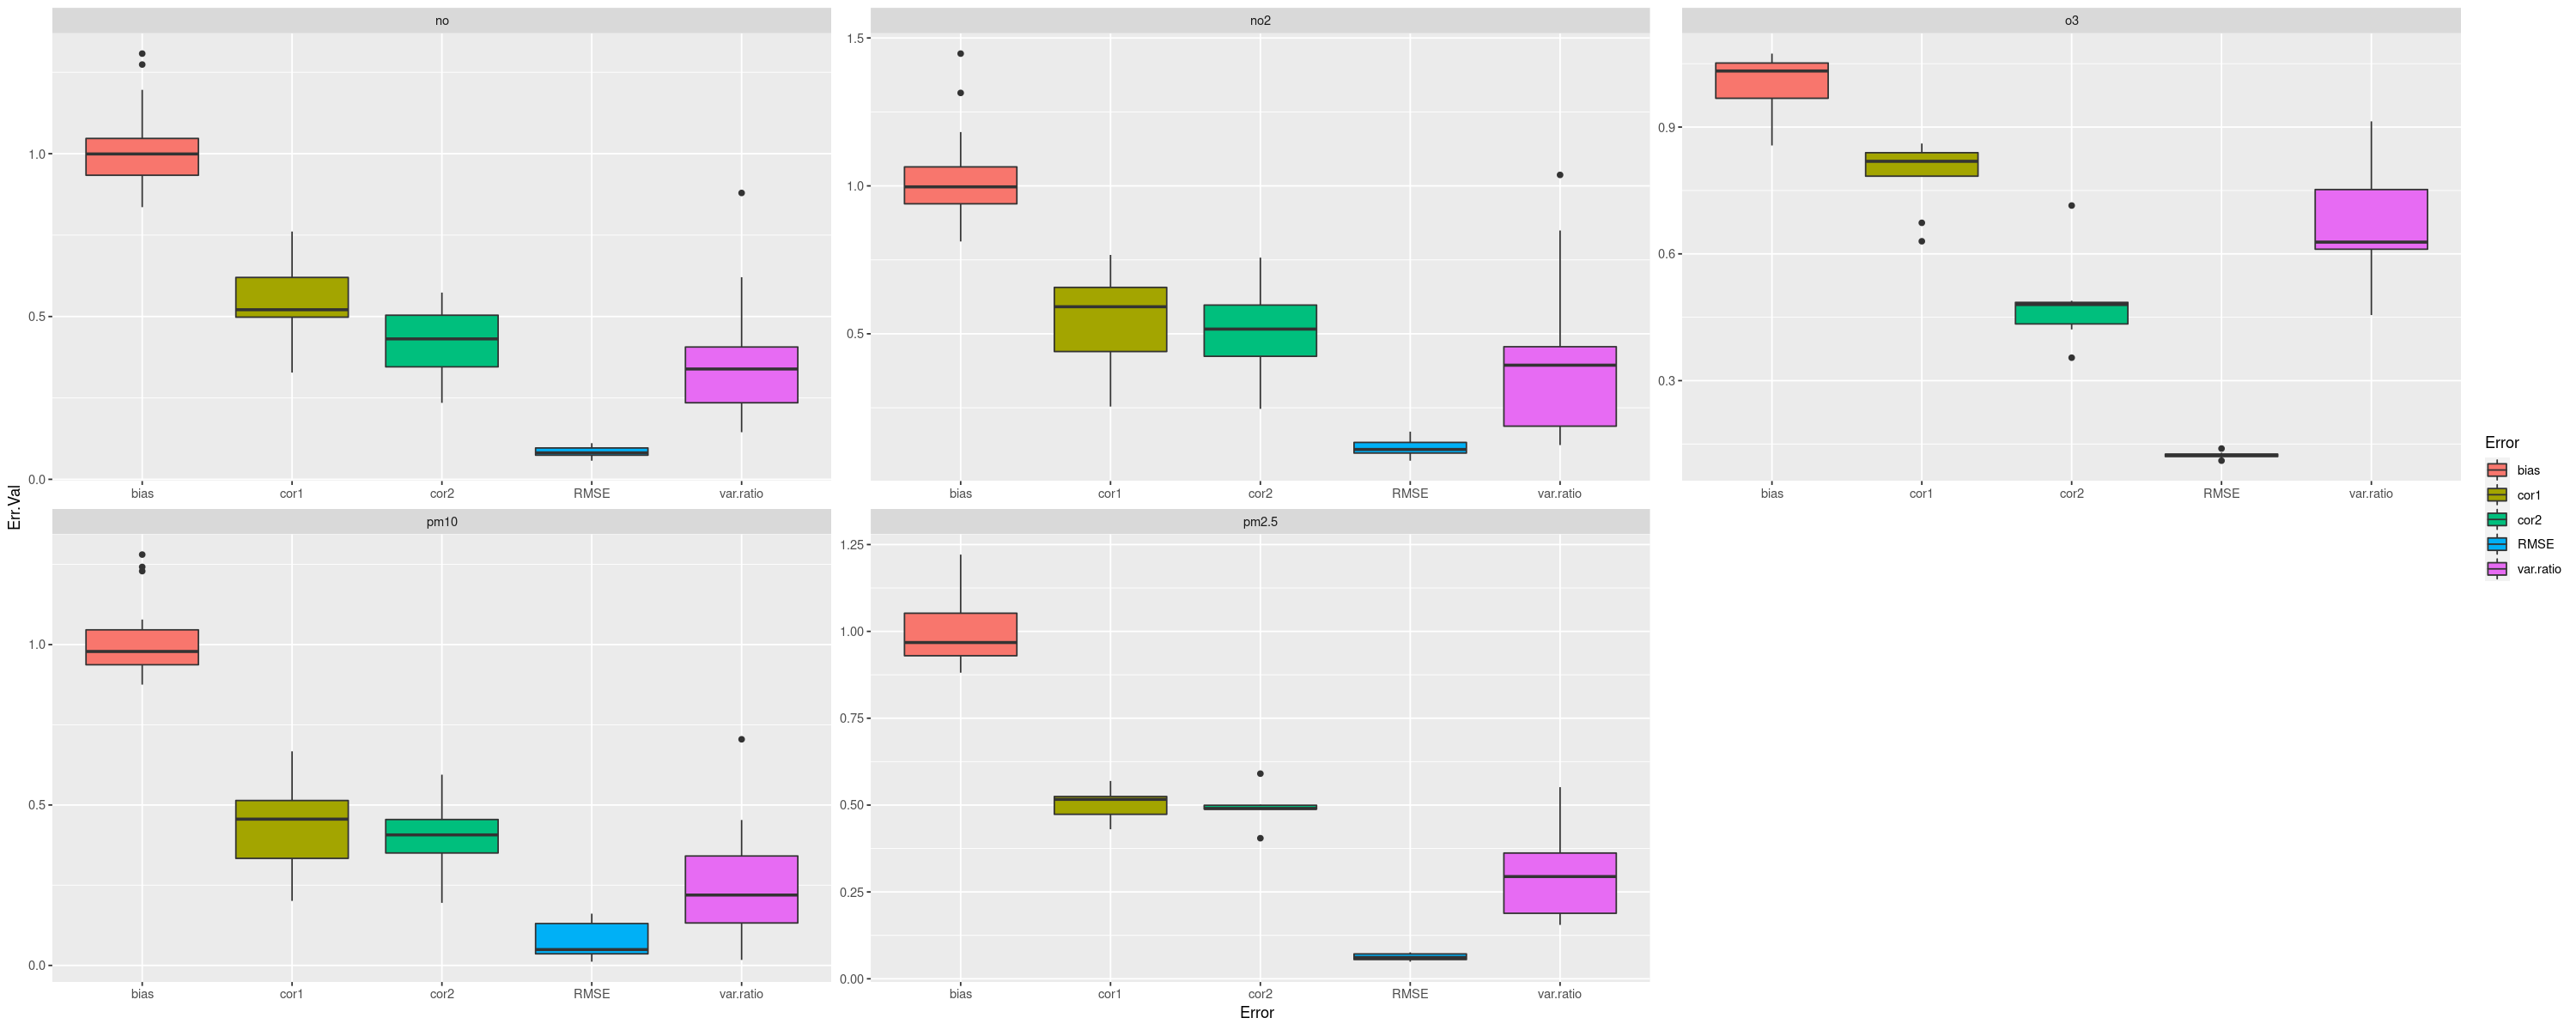

In [14]:
pivot.cv.df <- cv.df %>%
        pivot_longer(cols = c(3:ncol(cv.df)), 
                     names_to = "Error", values_to = "Err.Val")

plt <- ggplot(data=pivot.cv.df, aes(x=Error, y=Err.Val, fill=Error)) +
            geom_boxplot() + 
            facet_wrap(~variable, scale="free")
plt

# Save Results

In [15]:
write.csv(cv.df, "data/Cross-validation/lm.csv", row.names=F)

In [16]:
ggsave(
    "lm-CV.png",
    plot = plt,
    device = "png",
    path = "plots/cross-validation/lm/",
    width=12,
    height=8
)


Warning message:
“Removed 42 rows containing non-finite values (stat_boxplot).”
